In [1]:
import numpy as np
import torch
import torch.utils.data as dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# -- modules -- :
import RFconfidence_mask_2_split as ran
import module_split as module
import RF_module as RF


#For model
import torch.nn as nn
import torch.nn.functional as F

In [3]:
runname = '2_px1_ft11_splLARGEnotv_newfloss'
device = -1
batch_size=15

# -----
# Model, loss, & optimizer
# -----

in_channels=2
model = ran.model
if device >= 0:
    model.cuda(device)


if in_channels == 2:
    inputtype = 'V1_V4'
if in_channels == 191:
    inputtype = 'all_channels'

set_t = 'testing'

cuda0 = ran.cuda0
model.load_state_dict(torch.load(f'{runname}/epochs_192.model', map_location='cpu'))
model.eval()

# -----
# RF gaus maps
# ------
gaus = module.load_gausdata()

seen_images = module.load_ydata()

# ------
# Testing
# ------
# nn_testing = module.load_LFPdata('testing')
nn_training = module.load_LFPdata(set_t)

# testing_iterator = module.make_iterator(nn_testing, 'testing', batch_size, shuffle = False)
iterator = module.make_iterator(nn_training, set_t, batch_size, shuffle = False)


lossF = module.VGGLoss(device)



/scratch/users/lynnle/MonkeyProject/git/models/recetpivefield_stuff/module_split.py:38: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  param = Variable(param, volatile=True)


In [4]:
itera = iter(iterator)

In [5]:

hori_means, verti_means, std_avg = RF.extract_means_std()

confidence_mask = RF.make_confidence_mask(hori_means, verti_means, std_avg)
if device >= 0:
    confidence_mask = torch.from_numpy(confidence_mask.astype('float32')).to(cuda0)
else:
    confidence_mask = torch.from_numpy(confidence_mask.astype('float32'))


In [6]:

sample, target_indices = next(itera)
mean_signals  = sample[:,300]
gaus_expand_to_batch = gaus.expand([len(target_indices), 191, 240, 240])
mean_signals_expand_to_gaus = mean_signals.expand([240, 240, len(target_indices), 191])
mean_signals_expand_to_gaus = mean_signals_expand_to_gaus.transpose(0,2).transpose(1,3)
inputs = module.select_type_inputs(inputtype, gaus_expand_to_batch, mean_signals_expand_to_gaus)
img0 = seen_images[target_indices]


target_batch = seen_images[target_indices]
target_batch = target_batch.transpose(3,1).transpose(2,3)

if device >=0:
    inputs = inputs.to(cuda0)
    target_batch = target_batch.to(cuda0)

    
out = model(inputs)

out *= confidence_mask.expand_as(out)
target_batch *= confidence_mask.expand_as(target_batch)

loss = lossF(target_batch, out)

Text(0.5, 1.0, 'filled in')

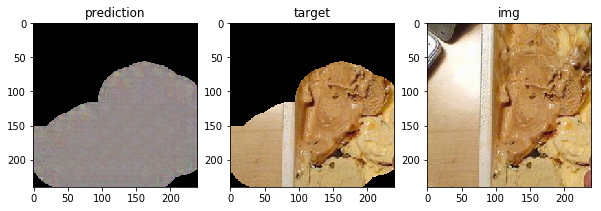

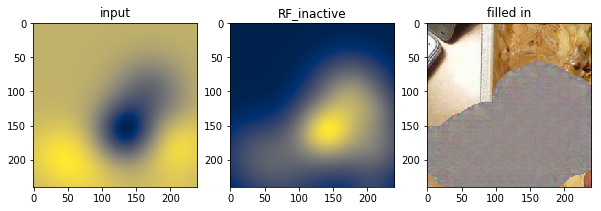

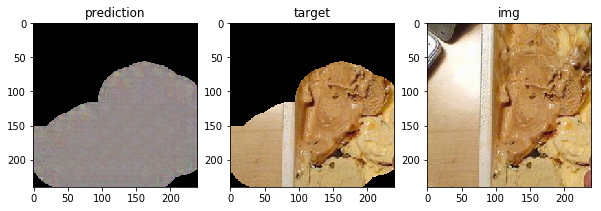

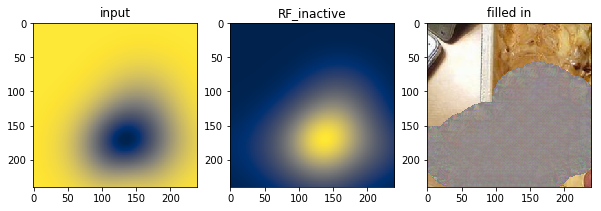

In [7]:
batch_nr = 0
V = 0

weighted_sum = gaus_expand_to_batch[batch_nr]
V1 = weighted_sum[:97].sum(0)
V4 = weighted_sum[97:].sum(0)
RF_inactive = np.stack((V1, V4))
RF_inactive = RF_inactive[V]

x = inputs[batch_nr][V].cpu().numpy()
x = x-x.min()/x.sum()
y = out[batch_nr].cpu().detach().numpy().transpose(1,2,0)
t = target_batch[batch_nr].cpu().numpy().transpose(1,2,0)
img = img0[batch_nr].cpu().numpy()
filled = (img - t)+y

plt.figure(figsize=(10,10))
plt.rcParams['figure.figsize']=(10,10)

plt.subplot(1,3,1)
plt.imshow(y)
plt.title('prediction')

plt.subplot(1,3,2)
plt.imshow(t)
plt.title('target')

plt.subplot(1,3,3)
plt.imshow(img)
plt.title('img')

###########
# RECEPTIVE FIELDS
###########
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(x,  cmap='cividis')
plt.title('input')
# - - - - 
plt.subplot(1,3,2)
plt.imshow(RF_inactive,  cmap='cividis')
plt.title('RF_inactive')

plt.subplot(1,3,3)
plt.imshow(filled, cmap = 'cividis')
plt.title('filled in')

# ---------------------------------------------
V = 1

weighted_sum = gaus_expand_to_batch[batch_nr]
V1 = weighted_sum[:97].sum(0)
V4 = weighted_sum[97:].sum(0)
RF_inactive = np.stack((V1, V4))
RF_inactive = RF_inactive[V]

x = inputs[batch_nr][V].cpu().numpy()
x = x-x.min()/x.sum()
y = out[batch_nr].detach().cpu().numpy().transpose(1,2,0)
t = target_batch[batch_nr].cpu().numpy().transpose(1,2,0)
img = img0[batch_nr].cpu().numpy()
filled = (img - t)+y


plt.figure(figsize=(10,10))
plt.rcParams['figure.figsize']=(10,10)

plt.subplot(1,3,1)
plt.imshow(y)
plt.title('prediction')

plt.subplot(1,3,2)
plt.imshow(t)
plt.title('target')

plt.subplot(1,3,3)
plt.imshow(img)
plt.title('img')

###########
# RECEPTIVE FIELDS
###########
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(x,  cmap='cividis')
plt.title('input')
# - - - - 
plt.subplot(1,3,2)
plt.imshow(RF_inactive,  cmap='cividis')
plt.title('RF_inactive')

plt.subplot(1,3,3)
plt.imshow(filled, cmap = 'cividis')
plt.title('filled in')


Text(0.5, 1.0, 'filled in')

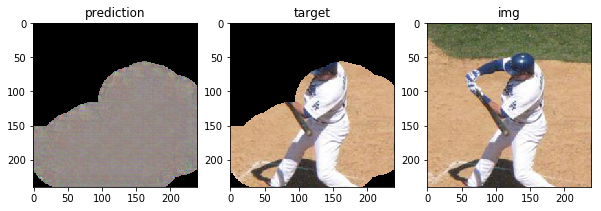

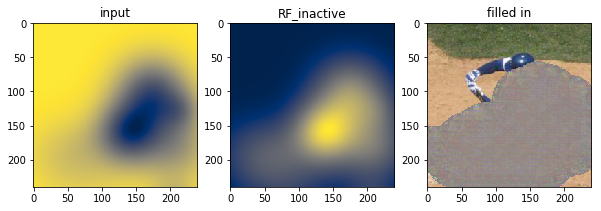

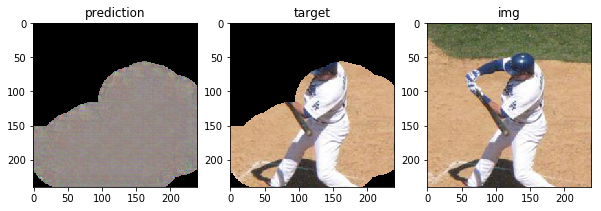

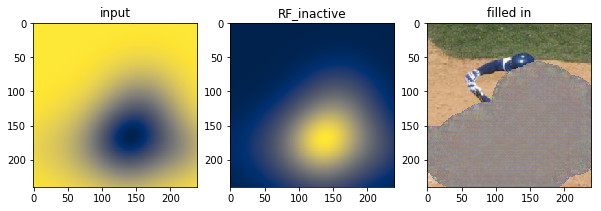

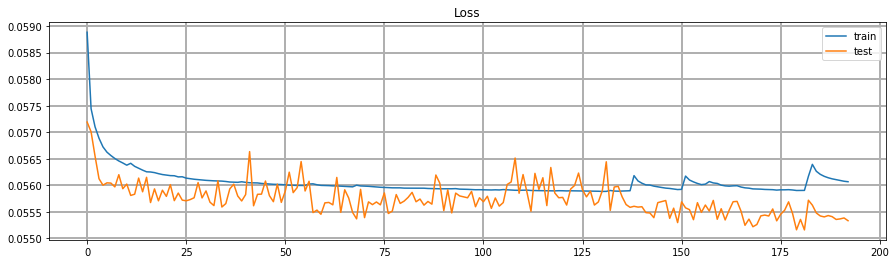

In [8]:
loss_train = np.load(runname + '/loss_train.npy', allow_pickle=True)
loss_test = np.load(runname+ '/loss_test.npy', allow_pickle=True)
epochs = len(loss_train)
plt.figure(figsize=(15,4))
# plt.ylim((1.1,2))
from_n = 0
to_n = epochs

plt.plot(loss_train[from_n:to_n], label='train', )
plt.plot(loss_test[from_n:to_n], label = 'test')
plt.legend()
plt.grid(True, linewidth=2)
plt.title('Loss')
plt.show()